In [2]:
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn

from data_loader import fetch_dataloader
from CNN import BinaryClimbCNN

In [4]:
if __name__ == "__main__":
    data_loaders, n_examples = fetch_dataloader(['train', 'val', 'test'], 0)
    batch_size = 64

    train_dataloader = data_loaders['train']
    val_dataloader = data_loaders['val']
    test_dataloader = data_loaders['test']

    GRID_DIMS = (18, 11)  # dimensions

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classes = ['6A+', '6B', '6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+', '8A', '8A+', '8B', '8B+']
    n_classes = len(classes)

    model = BinaryClimbCNN(n_classes).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    def train(dataloader, model, loss_fn, optimizer):
        model.train()
        loss_list, accuracy_list = [], []
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            X = X.float()

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            accuracy = correct / X.shape[0]

            loss_list.append(loss.item())
            accuracy_list.append(accuracy)

            if batch % 100 == 0:
                print(f"loss: {loss.item():>7f}, accuracy: {accuracy * 100:>0.1f}%")

        return loss_list, accuracy_list

    def evaluate(dataloader, model):
        """Evaluate the model on validation or test data."""
        model.eval()
        loss_list, accuracy_list = [], []
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                X = X.float()
                pred = model(X)
                loss = loss_fn(pred, y)

                # Calculate accuracy
                correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                accuracy = correct / X.shape[0]

                loss_list.append(loss.item())
                accuracy_list.append(accuracy)

        return np.mean(loss_list), np.mean(accuracy_list)

    epochs = 30
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        epoch_train_loss, epoch_train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
        epoch_val_loss, epoch_val_accuracy = evaluate(val_dataloader, model)

        train_loss.append(np.mean(epoch_train_loss))
        train_accuracy.append(np.mean(epoch_train_accuracy))
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        print(f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

    # Test evaluation after training
    test_loss, test_accuracy = evaluate(test_dataloader, model)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

(16025, 18, 11) (16025,) 16025
(2009, 18, 11) (2009,) 2009
(2009, 18, 11) (2009,) 2009
Epoch 1
-------------------------------
loss: 2.832726, accuracy: 4.7%
loss: 1.987923, accuracy: 26.6%
loss: 1.815420, accuracy: 28.1%
Train Loss: 2.0349, Train Accuracy: 0.2854
Val Loss: 1.8839, Val Accuracy: 0.3099
Epoch 2
-------------------------------
loss: 1.792870, accuracy: 40.6%
loss: 1.839704, accuracy: 35.9%
loss: 1.741790, accuracy: 35.9%
Train Loss: 1.8186, Train Accuracy: 0.3296
Val Loss: 1.8121, Val Accuracy: 0.3330
Epoch 3
-------------------------------
loss: 1.724190, accuracy: 32.8%
loss: 1.676011, accuracy: 31.2%
loss: 1.852362, accuracy: 34.4%
Train Loss: 1.7588, Train Accuracy: 0.3480
Val Loss: 1.7756, Val Accuracy: 0.3254
Epoch 4
-------------------------------
loss: 1.668483, accuracy: 37.5%
loss: 1.520781, accuracy: 43.8%
loss: 1.669664, accuracy: 39.1%
Train Loss: 1.7107, Train Accuracy: 0.3655
Val Loss: 1.7556, Val Accuracy: 0.3360
Epoch 5
-------------------------------
lo

In [6]:
import matplotlib.pyplot as plt

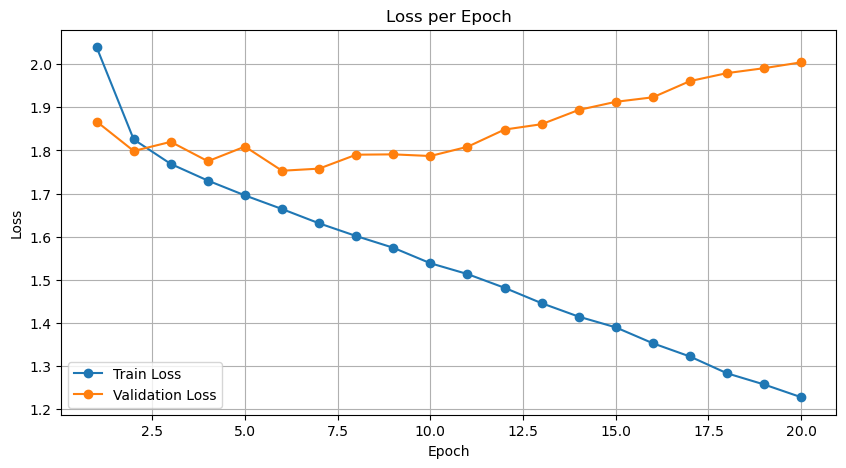

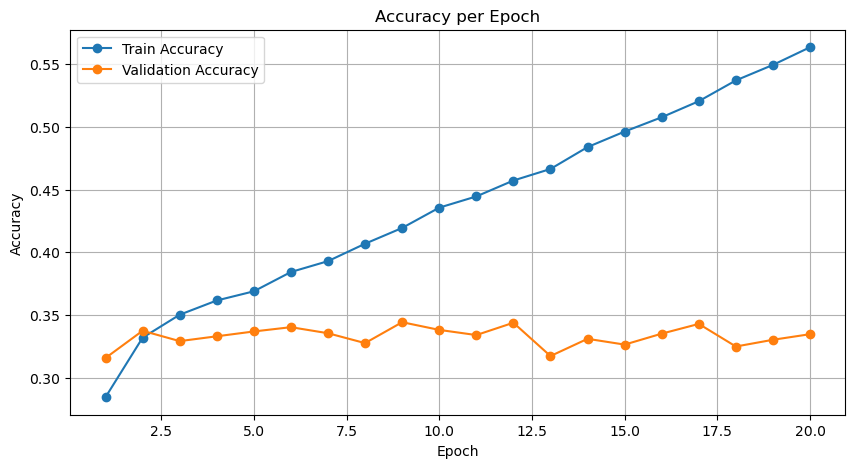

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

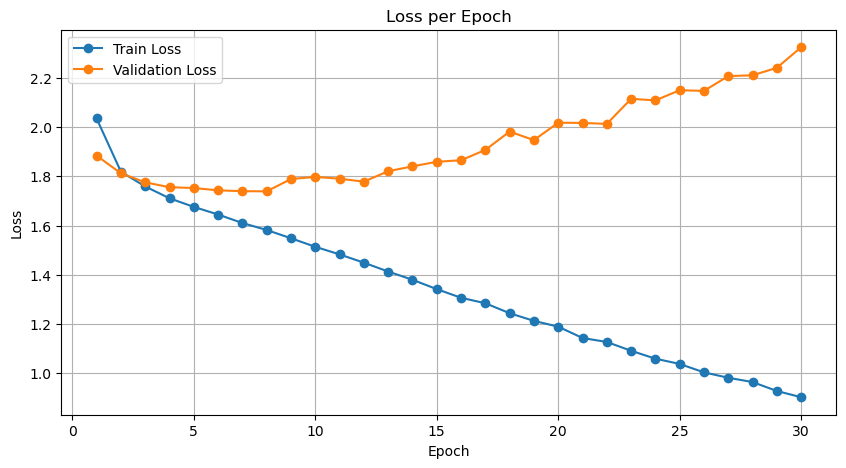

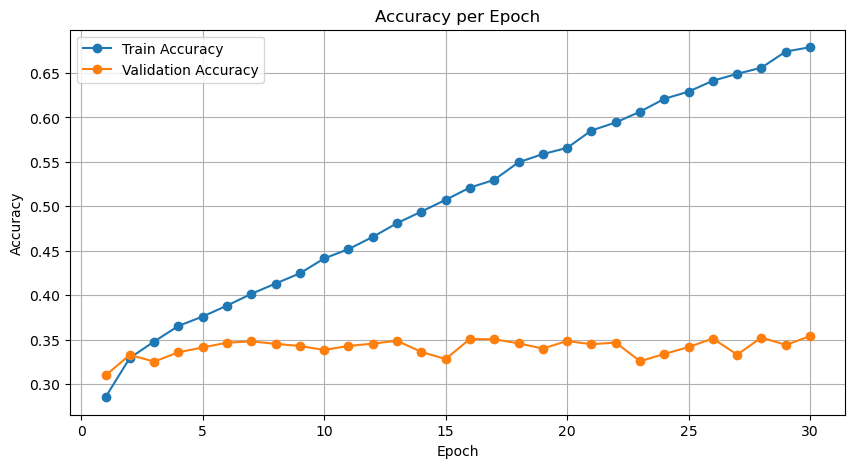

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()